# Notebook 02: Preparación de Datos

**Prueba Técnica - Modelador Junior**

---

## Objetivo

Preparar el dataset para el modelado:
1. Filtrar predicciones a 4 semanas de diferencia
2. Pivotar predicciones para tener un modelo por columna
3. Unir con valores reales
4. Crear variable objetivo: dirección del precio

**Variable Objetivo**: `direccion_real = 1` si `precio_real_futuro > precio_actual`, `0` si no.

---

## 1. Imports y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
np.random.seed(42)

print("Librerías cargadas")

Librerías cargadas


## 2. Carga de Datos

In [2]:
# Cargar datos
excel_file = '../data/raw/ReportDataALL_20250404 (1).xlsx'
df_real = pd.read_excel(excel_file, sheet_name='Real')
df_predicted = pd.read_excel(excel_file, sheet_name='Predicted')

print(f"Datos reales: {df_real.shape}")
print(f"Datos predichos: {df_predicted.shape}")

Datos reales: (66, 7)
Datos predichos: (1704, 9)


## 3. Filtrado de diferencia Temporal (4 Semanas)

In [ ]:
# Calcular la diferencia temporal
df_predicted['diference_days'] = (df_predicted['date_prediction'] - df_predicted['date_requested']).dt.days

# Filtrar a 4 semanas +- 1 dia de tolerancia
df_4weeks = df_predicted[
    (df_predicted['diference_days'] >= 27) & 
    (df_predicted['diference_days'] <= 29)
].copy()

print("="*70)
print("FILTRADO A 4 SEMANAS")
print("="*70)
print(f"\nRegistros originales: {len(df_predicted):,}")
print(f"Registros filtrados: {len(df_4weeks):,}")
print(f"Fechas únicas de solicitud: {df_4weeks['date_requested'].nunique()}")

print("\nPredicciones por modelo:")
model_counts = df_4weeks['model'].value_counts().sort_index()
print(model_counts)

# Analizar cobertura de cada modelo
print("\n" + "="*70)
print("ANÁLISIS DE COBERTURA POR MODELO")
print("="*70)
expected_predictions = df_4weeks['date_requested'].nunique()
print(f"\nPredicciones esperadas por modelo: {expected_predictions}")
print(f"\nCobertura real:")

for model in model_counts.index:
    count = model_counts[model]
    coverage = (count / expected_predictions) * 100
    print(f"   {model}: {count:3d} predicciones ({coverage:5.1f}%)")

models_to_keep = ['AA6KBD', 'IPBG4J', 'OBONV1']
df_4weeks = df_4weeks[df_4weeks['model'].isin(models_to_keep)].copy()


FILTRADO A 4 SEMANAS

Registros originales: 1,704
Registros filtrados: 228
Fechas únicas de solicitud: 56

Predicciones por modelo:
model
AA6KBD    86
HFWV8N    26
IPBG4J    43
LFHXNV    17
OBONV1    56
Name: count, dtype: int64

ANÁLISIS DE COBERTURA POR MODELO

Predicciones esperadas por modelo: 56

Cobertura real:
   AA6KBD:  86 predicciones (153.6%)
   HFWV8N:  26 predicciones ( 46.4%)
   IPBG4J:  43 predicciones ( 76.8%)
   LFHXNV:  17 predicciones ( 30.4%)
   OBONV1:  56 predicciones (100.0%)


## 4. Pivoteo de Predicciones

Convertir de formato largo a formato ancho (un modelo por columna).

## 4.1 Imputación Inteligente de Valores Nulos

**Regla de imputacion:**
1. Forward Fill: Usar última predicción válida del modelo
2. Si no hay valor previo, usar mediana del modelo específico


In [19]:
# Pivotar: cada modelo en su propia columna
df_pivot = df_4weeks.pivot_table(
    index=['date_requested', 'date_prediction'],
    columns='model',
    values='prediction'
).reset_index()

print("\nDataset pivotado:")
print(f"   Filas: {len(df_pivot)}")
print(f"   Columnas: {len(df_pivot.columns)}")
print(f"\n   Columnas: {list(df_pivot.columns)}")

# Verificar nulos antes de imputación
print("\n" + "="*70)
print("VALORES NULOs")
print("="*70)
models_cols = [col for col in df_pivot.columns if col not in ['date_requested', 'date_prediction']]
nulls_before = df_pivot[models_cols].isnull().sum()
if nulls_before.sum() > 0:
    print("\nModelos con valores nulos:")
    for col in models_cols:
        if nulls_before[col] > 0:
            pct = (nulls_before[col] / len(df_pivot)) * 100
            print(f"   {col}: {nulls_before[col]} nulos ({pct:.1f}%)")
else:
    print("\n[OK] No hay valores nulos")

display(df_pivot.head())


Dataset pivotado:
   Filas: 56
   Columnas: 5

   Columnas: ['date_requested', 'date_prediction', 'AA6KBD', 'IPBG4J', 'OBONV1']

VALORES NULOs

Modelos con valores nulos:
   AA6KBD: 13 nulos (23.2%)
   IPBG4J: 13 nulos (23.2%)


model,date_requested,date_prediction,AA6KBD,IPBG4J,OBONV1
0,2024-03-07,2024-04-04,NaN,NaN,488.738378
1,2024-03-14,2024-04-11,NaN,NaN,265.336645
2,2024-03-21,2024-04-18,NaN,NaN,394.036593
3,2024-03-28,2024-04-25,NaN,NaN,319.777665
4,2024-04-04,2024-05-02,NaN,NaN,277.921764


In [31]:
print("="*70)
print("IMPUTACIÓN")
print("="*70)

# Ordenar por fecha para forward fill temporal
df_pivot = df_pivot.sort_values('date_requested').reset_index(drop=True)

# Imputar cada modelo con su estrategia
for model in models_cols:
    nulls_count = df_pivot[model].isnull().sum()
    
    if nulls_count > 0:
        print(f"\n Imputando {model} ({nulls_count} nulos)")
        
        # Paso 1: Forward fill
        df_pivot[model] = df_pivot[model].fillna(method='ffill')
        
        # Paso 2: Si quedan nulos, usar mediana del modelo
        remaining_nulls = df_pivot[model].isnull().sum()
        if remaining_nulls > 0:
            model_median = df_pivot[model].median()
            df_pivot[model] = df_pivot[model].fillna(model_median)
            print(f"    Forward fill + mediana ({model_median:.2f})")

# Verificar que no queden nulos
print("\n" + "="*70)
print("VERIFICACIÓN")
print("="*70)
nulls_after = df_pivot[models_cols].isnull().sum()
if nulls_after.sum() == 0:
    print("\n0 valores nulos")

print(f"\nDataset pivot:")
print(f"   Filas: {len(df_pivot)}")
print(f"   Columnas: {len(df_pivot.columns)}")


IMPUTACIÓN

VERIFICACIÓN

0 valores nulos

Dataset pivot:
   Filas: 56
   Columnas: 5


## 5. Unión con Valores Reales

Necesitamos:
- Precio al momento del request (`value_at_request`)
- Precio 4 semanas después (`value_at_prediction`)

In [32]:
# Merge para obtener precio al momento del request
df_merged = df_pivot.merge(
    df_real[['date', 'value']],
    left_on='date_requested',
    right_on='date',
    how='left'
).drop('date', axis=1)

df_merged = df_merged.rename(columns={'value': 'value_at_request'})

# Merge para obtener precio en la fecha de predicción
df_merged = df_merged.merge(
    df_real[['date', 'value']],
    left_on='date_prediction',
    right_on='date',
    how='left'
).drop('date', axis=1)

df_merged = df_merged.rename(columns={'value': 'value_at_prediction'})

print("\nDataset merge:")
print(f"   Filas: {len(df_merged)}")
print(f"   Columnas: {len(df_merged.columns)}")

# Verificar nulos
nulls = df_merged.isnull().sum()
if nulls.sum() > 0:
    print("\nValores nulos encontrados:")
    print(nulls[nulls > 0])

display(df_merged.head())



Dataset merge:
   Filas: 56
   Columnas: 7

Valores nulos encontrados:
value_at_prediction    5
dtype: int64


,date_requested,date_prediction,AA6KBD,IPBG4J,OBONV1,value_at_request,value_at_prediction
0,2024-03-07,2024-04-04,357.438293,362.087507,488.738378,212.539897,229.151629
1,2024-03-14,2024-04-11,357.438293,362.087507,265.336645,222.152215,256.599110
2,2024-03-21,2024-04-18,357.438293,362.087507,394.036593,277.409972,377.644728
3,2024-03-28,2024-04-25,357.438293,362.087507,319.777665,237.324075,334.578301
4,2024-04-04,2024-05-02,357.438293,362.087507,277.921764,229.151629,304.996921


## 6. Creación de Variable Objetivo

Según los requisitos de la prueba:
- `direccion_real = 1` si el precio SUBIÓ (valor_futuro > valor_actual)
- `direccion_real = 0` si el precio BAJÓ o se mantuvo (valor_futuro ≤ valor_actual)

In [35]:
# Crear variable objetivo
df_merged['direction_real'] = (df_merged['value_at_prediction'] > df_merged['value_at_request']).astype(int)

print("\n" + "="*70)
print("VARIABLE OBJETIVO CREADA")
print("="*70)

# Distribución de clases
print("\nDistribución de la variable objetivo:")
value_counts = df_merged['direction_real'].value_counts().sort_index()
print(f"\n    0 (Bajada): {value_counts.get(0, 0)} ({value_counts.get(0, 0)/len(df_merged)*100:.1f}%)")
print(f"    1 (Subida): {value_counts.get(1, 0)} ({value_counts.get(1, 0)/len(df_merged)*100:.1f}%)")


VARIABLE OBJETIVO CREADA

Distribución de la variable objetivo:

    0 (Bajada): 32 (57.1%)
    1 (Subida): 24 (42.9%)


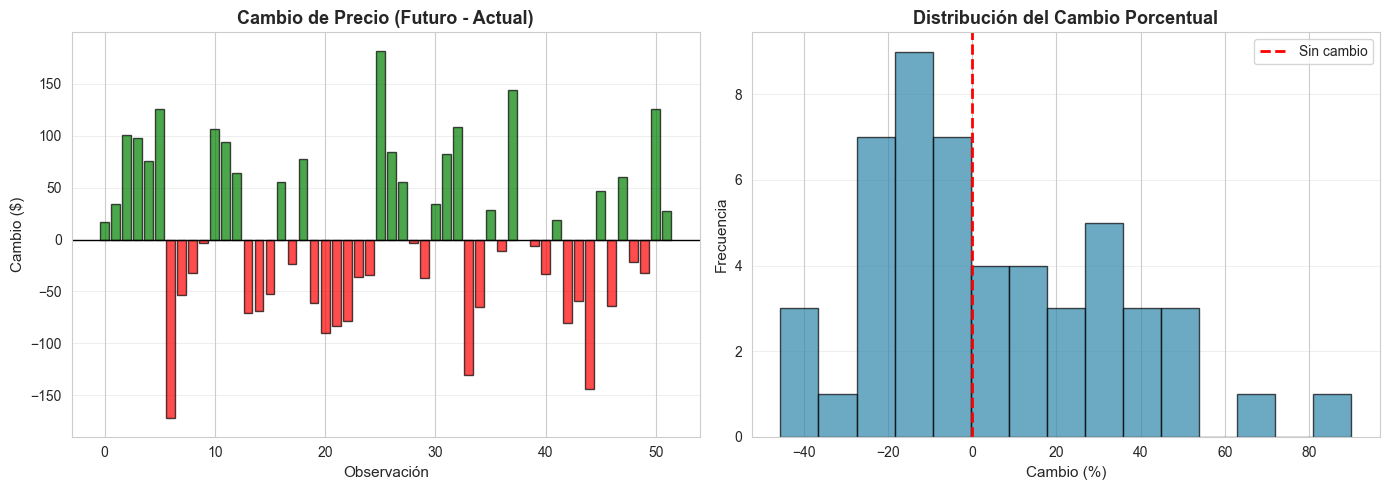


Grafica guardada


In [36]:
# Visualizar cambio de precios
df_merged['price_change'] = df_merged['value_at_prediction'] - df_merged['value_at_request']
df_merged['price_change_pct'] = (df_merged['price_change'] / df_merged['value_at_request']) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Distribución de cambios
colors = ['red' if x < 0 else 'green' for x in df_merged['price_change']]
axes[0].bar(range(len(df_merged)), df_merged['price_change'], color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Cambio de Precio (Futuro - Actual)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Observación', fontsize=11)
axes[0].set_ylabel('Cambio ($)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Grafico 2: Distribución porcentual
axes[1].hist(df_merged['price_change_pct'], bins=15, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Sin cambio')
axes[1].set_title('Distribución del Cambio Porcentual', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cambio (%)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/04_cambios_precio.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGrafica guardada")

## 7. Verificaciones Finales

In [40]:
print("\n" + "="*70)
print("VERIFICACIONES FINALES")
print("="*70)

# 1. Valores nulos
print("\nValores nulos por columna:")
nulls = df_merged.isnull().sum()
if nulls.sum() == 0:
    print("No hay valores nulos")
else:
    print(nulls[nulls > 0])

# 2. Duplicados
duplicates = df_merged.duplicated().sum()
if duplicates == 0:
    print(f"\nNo hay filas duplicadas")

# 3. Tipos de datos
print("\nTipos de datos:")
print(df_merged.info())

# 4. Estadísticas básicas
print("\n4. Estadísticas de precios:")
print(f"   Media Precio actual: ${df_merged['value_at_request'].mean():.2f}")
print(f"   Media Precio futuro: ${df_merged['value_at_prediction'].mean():.2f}")
print(f"   Cambio promedio: ${df_merged['price_change'].mean():+.2f} ({df_merged['price_change_pct'].mean():+.2f}%)")


VERIFICACIONES FINALES

Valores nulos por columna:
value_at_prediction    5
price_change           5
price_change_pct       5
dtype: int64

No hay filas duplicadas

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_requested       56 non-null     datetime64[ns]
 1   date_prediction      56 non-null     datetime64[ns]
 2   AA6KBD               56 non-null     float64       
 3   IPBG4J               56 non-null     float64       
 4   OBONV1               56 non-null     float64       
 5   value_at_request     56 non-null     float64       
 6   value_at_prediction  51 non-null     float64       
 7   direction_real       56 non-null     int64         
 8   price_change         51 non-null     float64       
 9   price_change_pct     51 non-null     float64       
dtypes: datetime64[ns](2), floa

## 8. Guardar Dataset Procesado

In [46]:
# Seleccionar columnas relevantes para guardar
# Solo los 3 modelos seleccionados
models_cols = ['AA6KBD', 'IPBG4J', 'OBONV1']

df_to_save = df_merged[[
    'date_requested', 'date_prediction',
    'value_at_request', 'value_at_prediction',
    'direction_real'
] + models_cols].copy()

# Guardar
output_file = '../data/processed/dataset_completo.csv'
df_to_save.to_csv(output_file, index=False)


print("\n" + "="*70)
print("DATASET GUARDADO")
print("="*70)
print(f"\nArchivo: {output_file}")
print(f"Dimensiones: {df_to_save.shape}")
print(f"Modelos incluidos: {models_cols}")


DATASET GUARDADO

Archivo: ../data/processed/dataset_completo.csv
Dimensiones: (56, 8)
Modelos incluidos: ['AA6KBD', 'IPBG4J', 'OBONV1']


In [ ]:
df_to_save

,date_requested,date_prediction,value_at_request,value_at_prediction,direction_real,AA6KBD,IPBG4J,OBONV1
0,2024-03-07,2024-04-04,212.539897,229.151629,1,357.438293,362.087507,488.738378
1,2024-03-14,2024-04-11,222.152215,256.599110,1,357.438293,362.087507,265.336645
2,2024-03-21,2024-04-18,277.409972,377.644728,1,357.438293,362.087507,394.036593
3,2024-03-28,2024-04-25,237.324075,334.578301,1,357.438293,362.087507,319.777665
4,2024-04-04,2024-05-02,229.151629,304.996921,1,357.438293,362.087507,277.921764
5,2024-04-11,2024-05-09,256.599110,382.123641,1,357.438293,362.087507,323.967149
6,2024-04-18,2024-05-16,377.644728,205.591867,0,357.438293,362.087507,320.551939
7,2024-04-25,2024-05-23,334.578301,280.790123,0,357.438293,362.087507,233.632756
8,2024-05-02,2024-05-30,304.996921,273.156698,0,357.438293,362.087507,449.644556
9,2024-05-09,2024-06-06,382.123641,378.943011,0,357.438293,362.087507,224.052230
